<a href="https://colab.research.google.com/github/dibadabir/Project1_A24/blob/main/Normal_Lesion_Classifier(V1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# File handling
import os  # For interacting with the file system
import random  # For random shuffling and seed setting


# Machine learning and deep learning
import numpy as np  # For numerical operations,arrays
import tensorflow as tf  # TensorFlow for building and training the deep learning model
from tensorflow.keras import layers, models  # Creating neural network layers and models


# Data splitting and evaluation metrics
from sklearn.model_selection import train_test_split  # For splitting the dataset into training and testing sets
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report  # For evaluating the model's performance


# Visualization libraries
import matplotlib.pyplot as plt  # For plotting graphs and charts
import seaborn as sns  # For advanced plotting, heatmaps (used for confusion matrices)


# Google Colab and file access
from google.colab import drive


In [2]:
# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# Path to the folders in Google Drive
lesion_folder = "/content/drive/MyDrive/1st Model/Test Lesion"
normal_folder = "/content/drive/MyDrive/1st Model/Test Normal"

In [4]:
# Load and organize images
def load_images_from_folder(folder, label):
    """Load images from the folder and return (image_path, label) pairs."""
    return [(os.path.join(folder, img), label) for img in os.listdir(folder) if img.lower().endswith(('png', 'jpg', 'jpeg'))]


# Load all images and assign labels
lesion_images = load_images_from_folder(lesion_folder, 'lesion')
normal_images = load_images_from_folder(normal_folder, 'normal')


# Combine all images and labels
all_images = lesion_images + normal_images
random.seed(42)  # Set seed to ensure consistent randomization
random.shuffle(all_images)

In [5]:
# Split the data (Train-Test Split)
image_paths, labels = zip(*all_images)

# Encode labels ('lesion' -> 1, 'normal' -> 0)
labels = np.array([1 if label == 'lesion' else 0 for label in labels])

# Use a fixed random state for consistent splits across runs
X_train, X_test, y_train, y_test = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42, stratify=labels
)

In [6]:
# Create data generators for training and testing
def preprocess_image(image_path):
    """Read, decode, resize, and normalize image."""
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])  # Resize to match input size for CNN
    image = image / 255.0  # Normalize pixel values to [0, 1]
    return image

def load_data(image_paths, labels):
    """Create a TensorFlow dataset from image paths and labels."""
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda x, y: (preprocess_image(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

# Create TensorFlow datasets
train_dataset = load_data(X_train, y_train).batch(32).shuffle(buffer_size=1000).prefetch(tf.data.AUTOTUNE)
test_dataset = load_data(X_test, y_test).batch(32).prefetch(tf.data.AUTOTUNE)

In [7]:
# Define the CNN model
def create_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),  # Dropout to reduce overfitting
        layers.Dense(1, activation='sigmoid')  # Sigmoid activation function for binary classification (lesion vs normal)
    ])
    return model


In [8]:
# Compile the model
model = create_model()
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
# Train the model
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=test_dataset)

Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 170s 7s/step - accuracy: 0.5170 - loss: 0.8912 - val_accuracy: 0.6900 - val_loss: 0.5777
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 58s 5s/step - accuracy: 0.7405 - loss: 0.5549 - val_accuracy: 0.7000 - val_loss: 0.5118
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 59s 4s/step - accuracy: 0.8499 - loss: 0.4016 - val_accuracy: 0.9000 - val_loss: 0.2612
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 84s 5s/step - accuracy: 0.9006 - loss: 0.2457 - val_accuracy: 0.9300 - val_loss: 0.2106
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 84s 5s/step - accuracy: 0.9350 - loss: 0.1739 - val_accuracy: 0.9500 - val_loss: 0.1581
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 59s 4s/step - accuracy: 0.9447 - loss: 0.1591 - val_accuracy: 0.9600 - val_loss: 0.1490
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 59s 4s/step - accuracy: 0.9239 - loss: 0.1639 - val_accuracy: 0.9600 - val_loss: 0.1207
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 81s 5s/step - accuracy: 0.8998 - loss: 0.2331 - val_accuracy: 0.9400 - val_loss

In [10]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_dataset)
print(f"\nTest accuracy: {test_acc:.2f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 984ms/step - accuracy: 0.9107 - loss: 0.1643

Test accuracy: 0.92


In [11]:
# Save the trained model
model_save_path = '/content/drive/MyDrive/skin_classification_model.h5'
model.save(model_save_path)
print(f"\nModel saved to: {model_save_path}")



Model saved to: /content/drive/MyDrive/skin_classification_model.h5


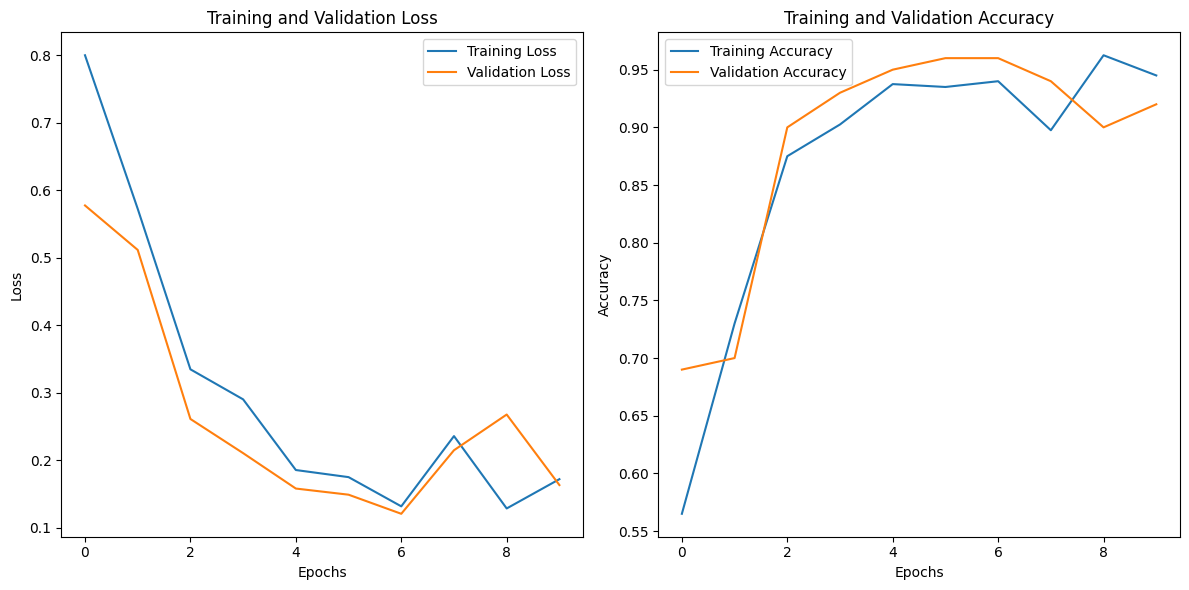

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 733ms/step


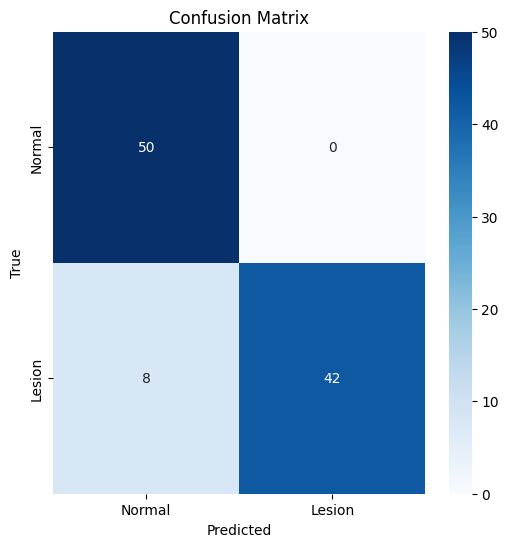

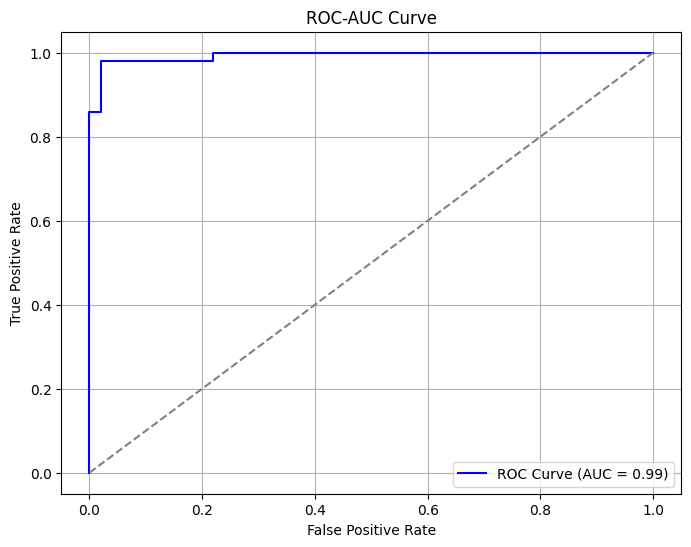


Classification Report:

              precision    recall  f1-score   support

      Normal       0.86      1.00      0.93        50
      Lesion       1.00      0.84      0.91        50

    accuracy                           0.92       100
   macro avg       0.93      0.92      0.92       100
weighted avg       0.93      0.92      0.92       100



In [12]:
# Plot Training and Validation Loss/Accuracy
def plot_training_history(history):
    """Plots the training and validation loss and accuracy."""
    plt.figure(figsize=(12, 6))
    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot Training History
plot_training_history(history)


# Evaluate the model and generate predictions
y_pred = model.predict(test_dataset)
y_pred_classes = (y_pred > 0.5).astype("int32").flatten()  # Binary classification threshold at 0.5
y_true = np.concatenate([y for x, y in test_dataset], axis=0)  # Extract true labels from the dataset


# Confusion Matrix
def plot_confusion_matrix(y_true, y_pred_classes):
    """Plots the confusion matrix."""
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Lesion"], yticklabels=["Normal", "Lesion"])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Plot Confusion Matrix
plot_confusion_matrix(y_true, y_pred_classes)


# ROC-AUC Curve
def plot_roc_auc(y_true, y_pred):
    """Plots the ROC-AUC curve."""
    fpr, tpr, _ = roc_curve(y_true, y_pred)  # Calculate False Positive Rate and True Positive Rate
    roc_auc = auc(fpr, tpr)  # Calculate AUC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random guessing
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-AUC Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

# Plot ROC_AUC
plot_roc_auc(y_true, y_pred)


# Classification Report
def generate_classification_report(y_true, y_pred_classes):
    """Generates a classification report."""
    report = classification_report(y_true, y_pred_classes, target_names=["Normal", "Lesion"])
    print("\nClassification Report:\n")
    print(report)

# Display Classification Report
generate_classification_report(y_true, y_pred_classes)